In [160]:
import numpy as np;
import scipy;
import seaborn as sns;
import pandas as pd;
import matplotlib.pyplot as plt;
from collections import defaultdict

In [161]:
general1 = np.random.normal(0, 1, 1000)
general2 = np.random.normal(0, 1, 1000)
general3 = np.random.normal(0, 1, 1000)


In [162]:
np.concatenate([general1, general2, general3])

array([ 1.29916144, -0.61591559, -1.15260243, ...,  2.01149356,
        1.87964873, -0.93588222])

In [163]:
general1.std()


1.030758970351362

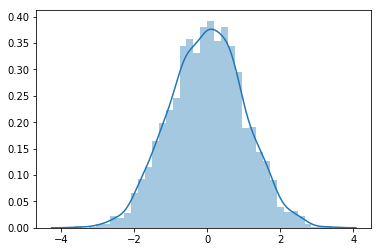

In [164]:
sns.distplot(np.concatenate([general1, general2, general3]))

In [261]:
class SamplingStrategy:
    """
    Abstract class for sampler
    """
    def generate_sample(self):
        """ Generates sample based on some input data and saves its state."""
        pass
    def mexp(self):
        """ Calculates ME of random sample."""
        pass
    def variance(self):
        """ Calculates variance of random sample."""
        pass
    

In [262]:
class RandomSampler(SamplingStrategy):
    def __init__(self, strats, samples):
        self.input = np.concatenate(strats)
        self.samples = samples
    
    def generate_sample(self):
        self.sample = np.random.choice(self.input, self.samples, replace=False)
        return self.sample
    
    def mexp(self):
        return np.average(self.sample)
    
    def variance(self):
        n = len(self.sample)
        N = len(self.input)
        return (np.std(self.sample) ** 2) * ((n - 1)/ n) * (N / (N - 1))

In [263]:
class ProportionalSampler(SamplingStrategy):
    def __init__(self, strats, samples):
        self.population = np.concatenate(strats)
        self.samples = samples
        self.__prepare_strats(strats)
        
    def __prepare_strats(self, strats):
        self.strats = defaultdict(dict)
        total = self.population.size
        for i, strat in enumerate(strats):
            self.strats[i]["w"] = 1.0 * strat.size / total
            self.strats[i]["data"] = strat
    
    def generate_sample(self):
        total_sample = np.array([])
        for i, strat in self.strats.items():
            strat["sample"] = np.random.choice(strat["data"], int(strat["w"]*self.samples), replace = False)
            total_sample = np.concatenate([total_sample, np.array(strat["sample"])])
        return total_sample
    
    def mexp(self):
        return sum([strat["w"] * np.average(strat["sample"]) for i, strat in self.strats.items()])
    
    def variance(self):
        variance = sum([strat["w"] * (np.std(strat["sample"])**2) for i, strat in self.strats.items()])
        mexp = self.mexp()
        additional = 0
        for i, strat in self.strats.items():
            additional += strat["w"] * (mexp - np.average(strat["sample"]))**2
        return variance + additional 

In [264]:
class OptimalSampler(SamplingStrategy):
    def __init__(self, strats, samples):
        self.population = np.concatenate(strats)
        self.samples = samples
        self.__prepare_strats(strats)
        
    def __prepare_strats(self, strats):
        self.strats = defaultdict(dict)
        total = self.population.size
        for i, strat in enumerate(strats):
            self.strats[i]["w"] = 1.0 * strat.size / total
            self.strats[i]["sigma"] = strat.std()
            self.strats[i]["data"] = strat
    
    def generate_sample(self):
        total = sum([strat["w"] * strat["sigma"] for i, strat in self.strats.items()])
         
        total_sample = np.array([])
        for i, strat in self.strats.items():
            strat["w_updated"] = 1.0 * strat["w"] * strat["sigma"]/total
            strat["sample"] = np.random.choice(strat["data"], int(self.samples * strat["w_updated"])) 
            total_sample = np.concatenate([total_sample, strat["sample"]])
        return total_sample
    
    def mexp(self):
        return sum([strat["w"] * np.average(strat["sample"]) for i, strat in self.strats.items()])
    
    def variance(self):
        variance = sum([strat["w"] * (np.std(strat["sample"]) ** 2) for i, strat in self.strats.items()])
        mexp = self.mexp()
        additional = 0
        for i, strat in self.strats.items():
            additional += strat["w"] * (mexp - np.average(strat["sample"]))**2
        return variance + additional 

In [265]:
class Simulator:
    def __init__(self, strats, samples):
        self.strategies = self.__init_selection_strategies(strats, samples)
            
    def __init_selection_strategies(self, strats, samples):
        def random_sampling():
            return RandomSampler(strats, samples)
        
        def proportional_sampling():
            return ProportionalSampler(strats, samples)
        
        def optimal_sampling():
            return OptimalSampler(strats, samples)
        
        strategies = {}
        strategies["random"] = random_sampling
        strategies["proportional"] = proportional_sampling
        strategies["optimal"] = optimal_sampling
        return strategies
    
    def run(self, iterations, strategy):
        sample_generator = self.strategies[strategy]()
        me = []
        var = []
        for i in range(iterations):
            sample_generator.generate_sample()
            me.append(sample_generator.mexp())
            var.append(sample_generator.variance())
        return (me, var)

In [266]:
def draw_results(result):
    fig, axs = plt.subplots(ncols=2)
    me = pd.Series(result[0], name="ME")
    variance = pd.Series(result[1], name="Variance")
    sns.distplot(me, ax=axs[0])
    sns.distplot(variance, ax=axs[1])
    print("ME estimation: " + str(np.average(me)) + " (sttdev=" + str(np.std(me)) + ")")
    print("Var estimation: " + str(np.average(variance)) + " (sttdev=" + str(np.std(variance)) + ")")

# Cлучай А: все страты имеют одинаковые матожидания и дисперсии.

In [267]:
data1 = np.random.normal(0, 1, 2000)
data2 = np.random.normal(0, 1, 1000)
data3 = np.random.normal(0, 1, 1000)

### Случайная выборка 500:

ME estimation: 0.010177027981086965 (sttdev=0.041802464854087215)
Var estimation: 0.9847979231383905 (sttdev=0.06005603734843246)


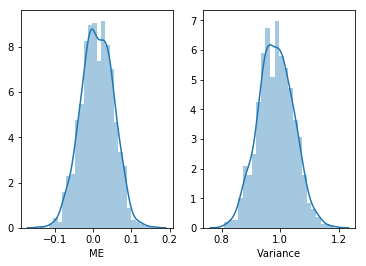

In [268]:
simulator = Simulator(strats=[data1, data2, data3], samples=500)
result = simulator.run(iterations=1000, strategy="random")
draw_results(result)

### Пропорциональная стратификация:

ME estimation: 0.0070191541054675545 (sttdev=0.04077535128366631)
Var estimation: 0.9891214092609871 (sttdev=0.06109402047663305)


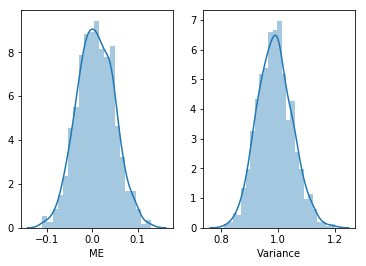

In [269]:
simulator = Simulator(strats=[data1, data2, data3], samples=500)
result = simulator.run(iterations=1000, strategy="proportional")
draw_results(result)

### Оптимальная:

ME estimation: 0.008854840595807925 (sttdev=0.04572066060148454)
Var estimation: 0.9894363303438585 (sttdev=0.06502430654365342)


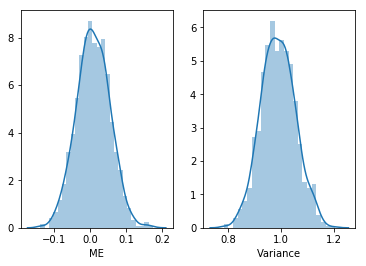

In [270]:
simulator = Simulator(strats=[data1, data2, data3], samples=500)
result = simulator.run(iterations=1000, strategy="optimal")
draw_results(result)

### Выборка 40:

ME estimation: 0.005350572805212112 (sttdev=0.15163399541308004)
Var estimation: 0.9323314542202144 (sttdev=0.2165859060016613)


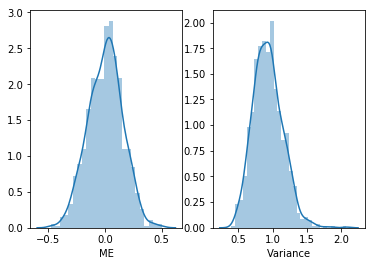

In [271]:
simulator = Simulator(strats=[data1, data2, data3], samples=40)
result = simulator.run(iterations=1000, strategy="random")
draw_results(result)

### Пропорциональная

ME estimation: 0.004817581079517804 (sttdev=0.15586169356411242)
Var estimation: 0.9675223030326896 (sttdev=0.22349729632518722)


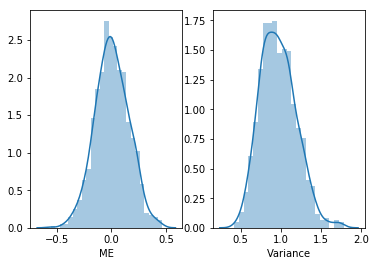

In [272]:
simulator = Simulator(strats=[data1, data2, data3], samples=40)
result = simulator.run(iterations=1000, strategy="proportional")
draw_results(result)

### Оптимальная

ME estimation: 0.014648814392678325 (sttdev=0.15825348854157498)
Var estimation: 0.9690710162995481 (sttdev=0.2296315641068046)


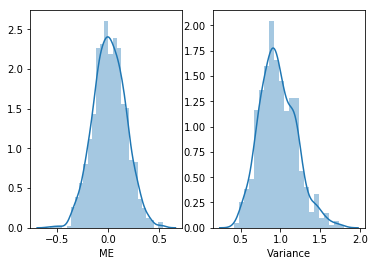

In [273]:
simulator = Simulator(strats=[data1, data2, data3], samples=40)
result = simulator.run(iterations=1000, strategy="optimal")
draw_results(result)

# Случай Б: разные матожидания, одинаковые дисперсии

### Генеральная совокупность

ME: 3.7726026553941345
Var: 7.072104415485763


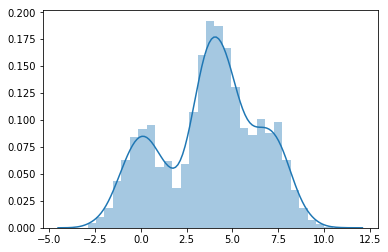

In [244]:
data1 = np.random.normal(4, 1, 2000)
data2 = np.random.normal(0, 1, 1000)
data3 = np.random.normal(7, 1, 1000)

population = np.concatenate([data1, data2, data3])

sns.distplot(population)
print("ME: " + str(np.average(population)))
print("Var: " + str(np.std(population)**2))

### Выборка 500: случайная выборка

ME estimation: 3.7662366956115605 (sttdev=0.11109471608436493)
Var estimation: 7.044468549808661 (sttdev=0.3345293919061634)


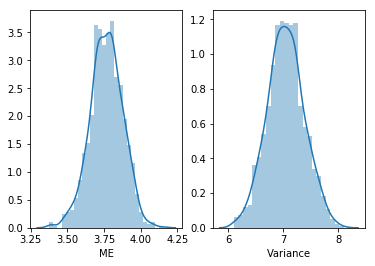

In [245]:
simulator = Simulator(strats=[data1, data2, data3], samples=500)
result = simulator.run(iterations=1000, strategy="random")
draw_results(result)

### Пропорциональная выборка

ME estimation: 3.774641275777055 (sttdev=0.04266521698161956)
Var estimation: 7.077156134679923 (sttdev=0.22101732679978425)


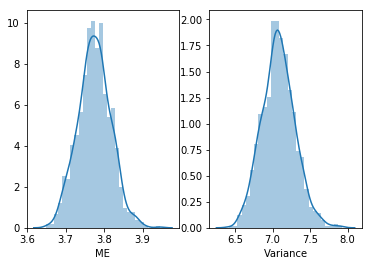

In [246]:
simulator = Simulator(strats=[data1, data2, data3], samples=500)
result = simulator.run(iterations=1000, strategy="proportional")
draw_results(result)

### Оптимальная выборка

ME estimation: 3.7739389299563335 (sttdev=0.04502257296678348)
Var estimation: 7.068637904383633 (sttdev=0.2447948215089329)


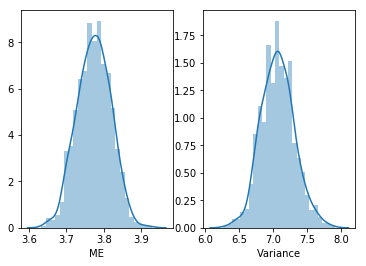

In [247]:
simulator = Simulator(strats=[data1, data2, data3], samples=500)
result = simulator.run(iterations=1000, strategy="optimal")
draw_results(result)

### Выборка 40
#### Случайная

ME estimation: 3.7892268073371205 (sttdev=0.41187658511243597)
Var estimation: 6.746444569156135 (sttdev=1.2591424785143044)


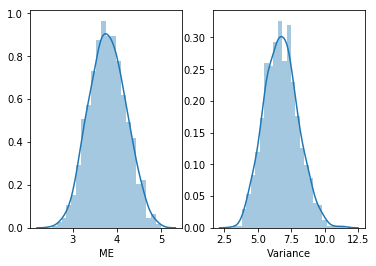

In [248]:
simulator = Simulator(strats=[data1, data2, data3], samples=40)
result = simulator.run(iterations=1000, strategy="random")
draw_results(result)

#### Пропорциональная

ME estimation: 3.7850776192229434 (sttdev=0.16117867160008795)
Var estimation: 7.06068176367544 (sttdev=0.8549578784794565)


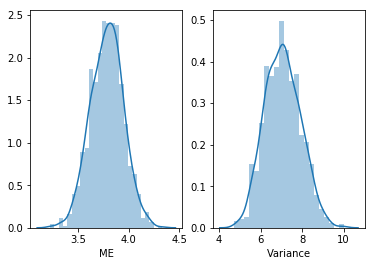

In [249]:
simulator = Simulator(strats=[data1, data2, data3], samples=40)
result = simulator.run(iterations=1000, strategy="proportional")
draw_results(result)

#### Оптимальная

ME estimation: 3.772330362686121 (sttdev=0.1608370909878027)
Var estimation: 7.04007629139581 (sttdev=0.8187394285410405)


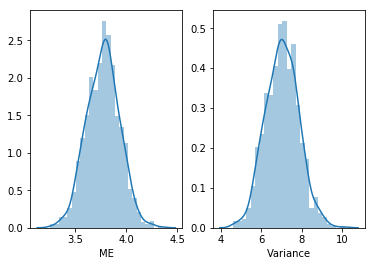

In [250]:
simulator = Simulator(strats=[data1, data2, data3], samples=40)
result = simulator.run(iterations=1000, strategy="optimal")
draw_results(result)

# Случай В: разные матожидания, разные дисперсии

### Генеральная совокупность

ME: 3.7655411163656236
Var: 12.800797522026388


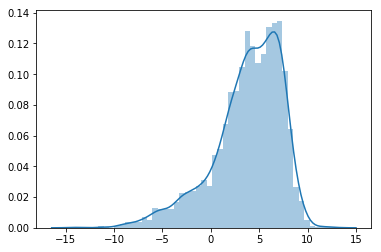

In [251]:
data1 = np.random.normal(4, 2, 2000)
data2 = np.random.normal(0, 4, 1000)
data3 = np.random.normal(7, 1, 1000)

population = np.concatenate([data1, data2, data3])

sns.distplot(population)
print("ME: " + str(np.average(population)))
print("Var: " + str(np.std(population)**2))

### Выборка 500
#### Случайная выборка

ME estimation: 3.7640266087816316 (sttdev=0.14989051002056497)
Var estimation: 12.749757699968294 (sttdev=0.9408409911771656)


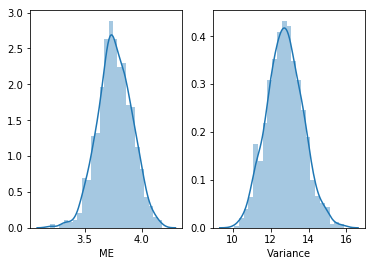

In [252]:
simulator = Simulator(strats=[data1, data2, data3], samples=500)
result = simulator.run(iterations=1000, strategy="random")
draw_results(result)

### Пропорциональная выборка

ME estimation: 3.7642214662522573 (sttdev=0.10094234750185382)
Var estimation: 12.844636035256798 (sttdev=0.8089090402081374)


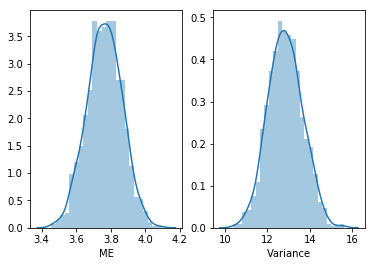

In [254]:
simulator = Simulator(strats=[data1, data2, data3], samples=500)
result = simulator.run(iterations=1000, strategy="proportional")
draw_results(result)

### Оптимальная выборка

ME estimation: 3.765968705688498 (sttdev=0.10275440645051453)
Var estimation: 12.794070325670718 (sttdev=0.7020207336052154)


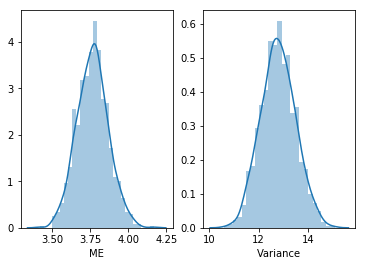

In [255]:
simulator = Simulator(strats=[data1, data2, data3], samples=500)
result = simulator.run(iterations=1000, strategy="optimal")
draw_results(result)

### Выборка 40
#### Случайная выборка

ME estimation: 3.796244916494628 (sttdev=0.5466466329551638)
Var estimation: 12.026058395475369 (sttdev=3.4895286165626596)


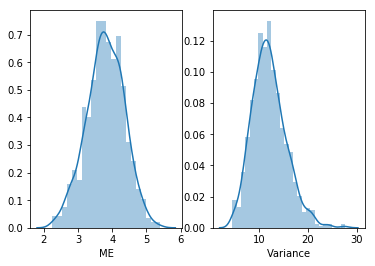

In [257]:
simulator = Simulator(strats=[data1, data2, data3], samples=40)
result = simulator.run(iterations=1000, strategy="random")
draw_results(result)

#### Пропорциональная выборка

ME estimation: 3.7702980156233563 (sttdev=0.39665017704219)
Var estimation: 12.481826404140342 (sttdev=3.0696647154900174)


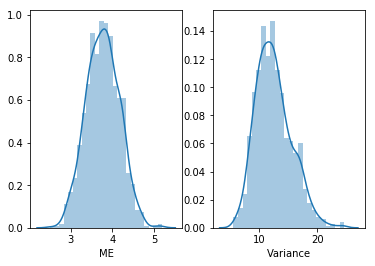

In [260]:
simulator = Simulator(strats=[data1, data2, data3], samples=40)
result = simulator.run(iterations=1000, strategy="proportional")
draw_results(result)

#### Оптимальная выборка

ME estimation: 3.7486380281479086 (sttdev=0.36558989942295)
Var estimation: 12.698110708188478 (sttdev=2.5344477908288137)


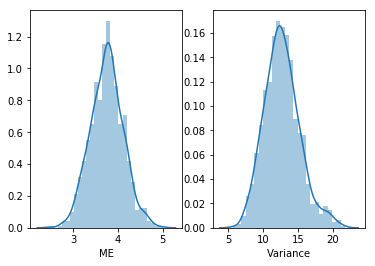

In [259]:
simulator = Simulator(strats=[data1, data2, data3], samples=40)
result = simulator.run(iterations=1000, strategy="optimal")
draw_results(result)

Выводы:
- При равных матожиданиях и дисперсиях страт, случайная выборка работает не хуже остальных;
- Если матожидания и дисперсии различны, то все 3 подхода дают примерно одинаковую оценку и ME и Var, но при оптимальном сэмплировании, дисперсия оценок немного меньше. Самая большая дисперсия оценок у случайного подхода.